In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

from ann import *

## Problem 1

### 1.1: Derivation

Our neural network is given by: $x \rightarrow l_1 \rightarrow \sigma \rightarrow l_2 \rightarrow \sigma \rightarrow y$, for which the cost function is $L(y, y^*) := (y^* - y)^2$. Note that $l_i(x) := W_i x + b_i$.

The SGD weight update rule for some parameter $p \in \{W_i, b_i\}$ is $\Delta p := -\alpha \frac{\partial L}{\partial p}$, for some learning rate $\alpha$. Using the chain rule, we can expand this computation. To build intuition, let's start out by computing the gradient of $L$ w.r.t. $W_2$: $\frac{\partial L}{\partial W_2} = \frac{\partial L}{\partial \sigma} \frac{\partial \sigma}{\partial l_2} \frac{\partial l_2}{\partial W_2}$. Where $\mathrm{input}$ refers to the input to any particular layer:
* $\frac{\partial L}{\partial \sigma}$ is easy: $2(\mathrm{input} - y)$. Note that, here, $\mathrm{input} = y^*$ by definition.
* $\frac{\partial \sigma}{\partial l_2}$ depends on the choice of $\sigma$. We use sigmoid, i.e. $\sigma(x) = \frac{1}{1 + e^{-x}}$. Therefore, the derivative is: $\sigma(\mathrm{input}) (1 - \sigma(\mathrm{input}))$; this is a well-known fact.
* $\frac{\partial \sigma}{\partial W_2}$ is a simple matrix calculus identity: $\mathrm{input}^T$.
* Therefore, $\frac{\partial L}{\partial W_2} = 2(\mathrm{input}_\mathrm{loss} - y) * \sigma(\mathrm{input}_\mathrm{act}) (1 - \sigma(\mathrm{input}_\mathrm{act})) * \mathrm{input}_\mathrm{layer 2}^T$.

These three steps are sufficient to elucidate an algorithm that can be used to backpropagate *in general* through an arbitrary number of FC/Sigmoid layers: to get the gradient w.r.t any parameter, just iterate backwards through the network, and keep a running product of the individual gradients. More concretely:
* Store the input from the previous layer during forward propagation.
* During backpropagation: compute the gradient of the current layer's output w.r.t to its weights, then multiply that by the gradient coming from the previous backprop layer. This yields the gradient of $L$ w.r.t each parameter, which can be used to perform one SGD update.
* Return the gradient of the layer's output w.r.t its input, multiplied by the gradient coming from the previous backprop layer, so that the next backprop can use it (chain rule).

That's it!

For completeness (I think the question asks for this) here are formulas for all the weights in this two-layer net. The notation is pretty clunky.
* $\frac{\partial L}{\partial W_2} = 2(\mathrm{input}_\mathrm{loss} - y) * \sigma(\mathrm{input}_\mathrm{act2}) (1 - \sigma(\mathrm{input}_\mathrm{act2})) * \mathrm{input}_\mathrm{layer 2}^T$
* $\frac{\partial L}{\partial b_2} = 2(\mathrm{input}_\mathrm{loss} - y) * \sigma(\mathrm{input}_\mathrm{act2}) (1 - \sigma(\mathrm{input}_\mathrm{act2}))$
* $\frac{\partial L}{\partial W_1} = 2(\mathrm{input}_\mathrm{loss} - y) * \sigma(\mathrm{input}_\mathrm{act2}) (1 - \sigma(\mathrm{input}_\mathrm{act2})) * W_2 * \sigma(\mathrm{input}_\mathrm{act1}) (1 - \sigma(\mathrm{input}_\mathrm{act1})) * \mathrm{input}_\mathrm{layer 1}^T$
* $\frac{\partial L}{\partial b_1} = 2(\mathrm{input}_\mathrm{loss} - y) * \sigma(\mathrm{input}_\mathrm{act2}) (1 - \sigma(\mathrm{input}_\mathrm{act2})) * W_2 * \sigma(\mathrm{input}_\mathrm{act1}) (1 - \sigma(\mathrm{input}_\mathrm{act1}))$

### 1.2: Train Network

In [3]:
# Load + pre-process data

def get_data(fname: str, ver: str):
    assert ver in ["train", "test"]
    mat = scipy.io.loadmat(fname)
    x, y = np.asarray(mat[f"X_{ver}"]), np.asarray(mat[f"y_{ver}"]).squeeze() % 10
    y_one_hot = np.eye(10)[y]
    
    return x, y_one_hot

(train_x, train_y), (test_x, test_y) = (
    get_data("mnist_training.mat", ver="train"),
    get_data("mnist_test.mat", ver="test")
)

In [4]:
# Define NN
nn = Network(layers=[
    Dense(784, 20),
    Sigmoid(),
    Dense(20, 10),
    Sigmoid()
])

In [5]:
# Train NN
nn.fit(train_x, train_y, epochs=5000, lr=2e-3)

Epoch 0: loss = 10907.371607182808 | acc = 0.11066666666666666
Epoch 250: loss = 910.1372447528748 | acc = 0.8253333333333334
Epoch 500: loss = 506.5525042808875 | acc = 0.907
Epoch 750: loss = 370.51845886848173 | acc = 0.9303333333333333
Epoch 1000: loss = 292.3930013399754 | acc = 0.945
Epoch 1250: loss = 238.86354427759187 | acc = 0.9533333333333334
Epoch 1500: loss = 204.21324415766148 | acc = 0.959
Epoch 1750: loss = 179.29183969757693 | acc = 0.9633333333333334
Epoch 2000: loss = 160.36850957864067 | acc = 0.9673333333333334
Epoch 2250: loss = 147.72472028833332 | acc = 0.968
Epoch 2500: loss = 138.6903548285787 | acc = 0.969
Epoch 2750: loss = 132.6512903070529 | acc = 0.9696666666666667
Epoch 3000: loss = 127.58404427412142 | acc = 0.9703333333333334
Epoch 3250: loss = 121.748829731759 | acc = 0.9706666666666667
Epoch 3500: loss = 115.03686952243578 | acc = 0.9723333333333334
Epoch 3750: loss = 110.94686631486343 | acc = 0.9726666666666667
Epoch 4000: loss = 107.68510025751 | 

### 1.3: Test Network

In [6]:
def get_acc(cur_nn, x, y):
    y_pred = cur_nn.forward(x)
    acc = (y_pred.argmax(axis=1) == y.argmax(axis=1)).mean()
    return acc

In [7]:
print(f"Final test set prediction accuracy: {get_acc(nn, test_x, test_y)}")

Final test set prediction accuracy: 0.8456666666666667


### 1.4: Pick Number of Hidden Neurons
We use the suggested size of 20. As we all know, there is no specific principled method to choose hyperparameters, other than modifying them and observing the effects. Since the pset instructions note that 20 is appropriate, no additional work is required.

### 1.5: Randomly Sample Initializations
After running on 10 different random initializations, it appears that the neural network is fairly robust to changes in its initial weights, though there are some fluctuations. Overall, the performance is comparable across runs, but it might be helpful in practice to run the neural net multiple times to ensure that poor performance is not just due to bad luck.

In [13]:
def train_and_eval():
    nn = Network(layers=[
        Dense(784, 20),
        Sigmoid(),
        Dense(20, 10),
        Sigmoid()
    ])
    nn.fit(train_x, train_y)
    return get_acc(nn, test_x, test_y)

data = [train_and_eval() for _ in range(10)]

Epoch 0: loss = 14371.019678447388 | acc = 0.10266666666666667
Epoch 250: loss = 1083.9599935251206 | acc = 0.7703333333333333
Epoch 500: loss = 490.7839752164466 | acc = 0.9116666666666666
Epoch 750: loss = 354.1803984240168 | acc = 0.9313333333333333
Epoch 1000: loss = 283.45470275263165 | acc = 0.9453333333333334
Epoch 1250: loss = 239.79013109778822 | acc = 0.9516666666666667
Epoch 1500: loss = 209.20487516146977 | acc = 0.958
Epoch 1750: loss = 186.6861289603924 | acc = 0.962
Epoch 2000: loss = 171.45605597954923 | acc = 0.9653333333333334
Epoch 2250: loss = 160.05261753397332 | acc = 0.9663333333333334
Epoch 2500: loss = 150.14462112468794 | acc = 0.9673333333333334
Epoch 2750: loss = 141.5817609450404 | acc = 0.9686666666666667
Epoch 3000: loss = 135.08027958802668 | acc = 0.9696666666666667
Epoch 3250: loss = 127.75200794446606 | acc = 0.9716666666666667
Epoch 3500: loss = 122.57875839250856 | acc = 0.972
Epoch 3750: loss = 117.90104560793188 | acc = 0.9726666666666667
Epoch 40

Epoch 4500: loss = 92.72525699602069 | acc = 0.9776666666666667
Epoch 4750: loss = 90.57543464698608 | acc = 0.978
Epoch 0: loss = 10897.770699101737 | acc = 0.07966666666666666
Epoch 250: loss = 1401.3388829347427 | acc = 0.6223333333333333
Epoch 500: loss = 1009.9820064476708 | acc = 0.7406666666666667
Epoch 750: loss = 880.0204660929708 | acc = 0.757
Epoch 1000: loss = 817.7573376950141 | acc = 0.7653333333333333
Epoch 1250: loss = 585.9785002787319 | acc = 0.856
Epoch 1500: loss = 519.742515434421 | acc = 0.8636666666666667
Epoch 1750: loss = 483.25221783316357 | acc = 0.867
Epoch 2000: loss = 457.94989736807076 | acc = 0.8706666666666667
Epoch 2250: loss = 441.17769497590433 | acc = 0.873
Epoch 2500: loss = 427.37062507430215 | acc = 0.8746666666666667
Epoch 2750: loss = 418.5351253887824 | acc = 0.8753333333333333
Epoch 3000: loss = 411.84803255132545 | acc = 0.8756666666666667
Epoch 3250: loss = 407.22570909780575 | acc = 0.8766666666666667
Epoch 3500: loss = 402.8434847752935 |

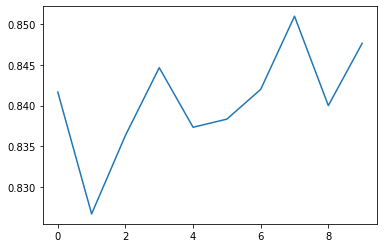

In [14]:
plt.plot(data)
plt.show()

### 1.6: Visualize Weights

Each image represents the strength of the connection from all 784 input pixels to that neuron.

One can interpret these maps as the "pattern" each particular neuron is searching for.

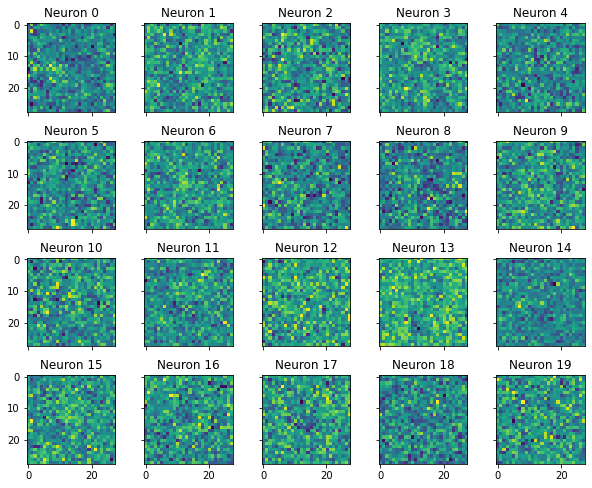

In [10]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 5),
                 axes_pad=0.4,
                 )

for i, ax in enumerate(grid):
    weight_row = nn.layers[0].w.T[i]
    ax.imshow(np.reshape(weight_row, (28, 28)))
    ax.set_title(f"Neuron {i}")

plt.show()